# Graph Construction

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp

In [88]:
def graph_construct(num_node):
    ''' undirected weighted graph construction'''
    G = nx.Graph()
    G.add_nodes_from(
        [i for i in range(0, num_node)]
    )
    G.add_edges_from(
        [ (i, j, {'weight': np.random.uniform(1.0, 5.0)*100//1/100}) 
         for i in range(0, num_node) for j in range(0, num_node)]
    )
    
    return G

In [89]:
def drop_random_edges(G, threshold):
    final_G = nx.Graph()
    final_G.add_nodes_from(G.nodes(data=True))
    
    '''
    remove edges with weight smaller than threshold value
    '''
    edges = filter(lambda e: True if e[2]['weight'] >= threshold else False, G.edges(data=True))
    final_G.add_edges_from(edges)
    
    """
    remove all the nodes that are not connected(isolated nodes)
    """
    for curr_node in G.nodes():
        if len(list(nx.all_neighbors(final_G, curr_node))) == 0:
            final_G.remove_node(curr_node)
    return final_G

In [90]:
G = graph_construct(100)
final_G = drop_random_edges(G, 4.5)

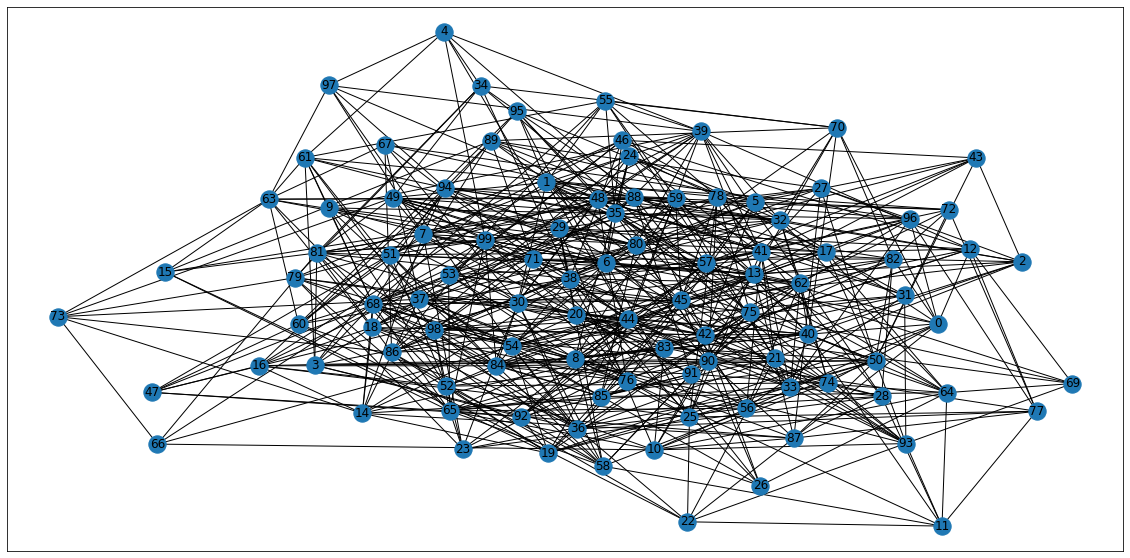

In [91]:
plt.figure(figsize=(20,10))
nx.draw_networkx(final_G)

In [92]:
print('number_of_nodes:{}'.format(len(final_G)))
print('number_of_edges:{}'.format(final_G.number_of_edges()))

number_of_nodes:100
number_of_edges:627


In [93]:
''' adjacency matrix of final_G'''
A = nx.adjacency_matrix(final_G)
print(A.todense())

[[0.   0.   0.   ... 0.   0.   4.88]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [4.88 0.   0.   ... 0.   0.   0.  ]]


In [94]:
sp.sparse.save_npz('constructed_graph.npz', A)

# Extract overlapping G1 and G2 from G

In [95]:
original_G = nx.from_numpy_matrix(sp.sparse.load_npz('constructed_graph.npz').todense())

## Compute number of overlapping and non-overlapping nodes

In [71]:
def network_split(G, ovl_p):
    G1 = nx.Graph()
    G2 = nx.Graph()
    
    ovl_p = ovl_p*100
    G_n_num = G.number_of_nodes()
    non_ovl_p = 100-ovl_p
    
    ''' estimate the number of overlapping nodes'''
    a = round(G_n_num/(non_ovl_p*2 + ovl_p),1)
    ovl_n_num = int(a * ovl_p)
    
    ''' estimate the number of non-overlapping nodes in each g1 and g2'''
    non_ovl_n_num = int(a * non_ovl_p)
    
    #sub_graph = G.subgraph([np.random.randint(0, )])
    
    return ovl_n_num, non_ovl_n_num

In [72]:
expected_ovl_num, expected_non_ovl_num = network_split(original_G, 0.1)
sub_g_n_num = expected_ovl_num + expected_non_ovl_num
print("number of expected overlapping nodes: {}".format(expected_ovl_num))
print("number of expected non-overlapping nodes: {}".format(expected_non_ovl_num))
print("number_of_node_in_subgraph: {}".format(sub_g_n_num))

number of expected overlapping nodes: 5
number of expected non-overlapping nodes: 45
number_of_node_in_subgraph: 50


## generate two subgraphs G1 and G2

In [73]:
def generate_subgraph(G, n):
    
    sub_g = nx.Graph()
    sub_g_nodes = []
    sub_g_edges = []
    start = np.random.choice(G.nodes())
    sub_g_nodes = [start]
    
    curr = start
    while len(sub_g_nodes) < n:
        sub_g_size = len(sub_g_nodes)
        neighborhood = list(G.neighbors(curr))
        if len(neighborhood) != 0:#if neighbors exist
            for j in neighborhood:
                e1, e2 = create_edge(G,curr,j)
                if e1 not in sub_g_edges and j not in sub_g_nodes:
                        sub_g_nodes.append(j)
                        sub_g_edges.append(e1)
                        sub_g_edges.append(e2)
                        break
                elif e1 not in sub_g_edges and j in sub_g_nodes:
                        sub_g_edges.append(e1)
                        sub_g_edges.append(e2)
                        break
                else:
                    continue
                    
            if len(sub_g_nodes) == sub_g_size:#if nothing added to node list
                idx = sub_g_nodes.index(curr) - 1
                curr = sub_g_nodes[idx]
            else:
                curr = sub_g_nodes[-1]
                
    sub_g.add_nodes_from(sub_g_nodes)
    sub_g.add_edges_from(sub_g_edges)
                
    return sub_g
            

def create_edge(G,n1,n2):
    # for undirected graph
    edge_w = G.get_edge_data(n1,n2)
    out_edge = (n1,n2, edge_w)
    in_edge = (n2,n1, edge_w)
    
    return out_edge, in_edge

In [74]:
g1 = generate_subgraph(original_G, sub_g_n_num)
g2 = generate_subgraph(original_G, sub_g_n_num)
print("number of g1 nodes: {}".format(g1.number_of_nodes()))
print("number of g1 edges: {}".format(g1.number_of_edges()))
print("number of g2 nodes: {}".format(g2.number_of_nodes()))
print("number of g2 edges: {}".format(g2.number_of_edges()))

number of g1 nodes: 50
number of g1 edges: 105
number of g2 nodes: 50
number of g2 edges: 103


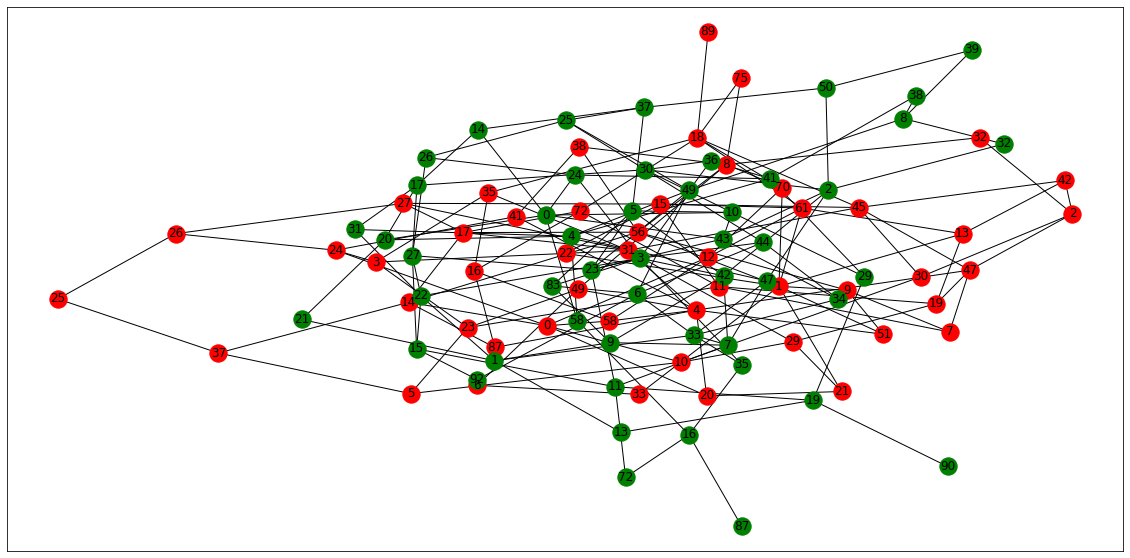

In [75]:
plt.figure(figsize=(20,10))
nx.draw_networkx(g1, node_color='red')
nx.draw_networkx(g2, node_color='green')

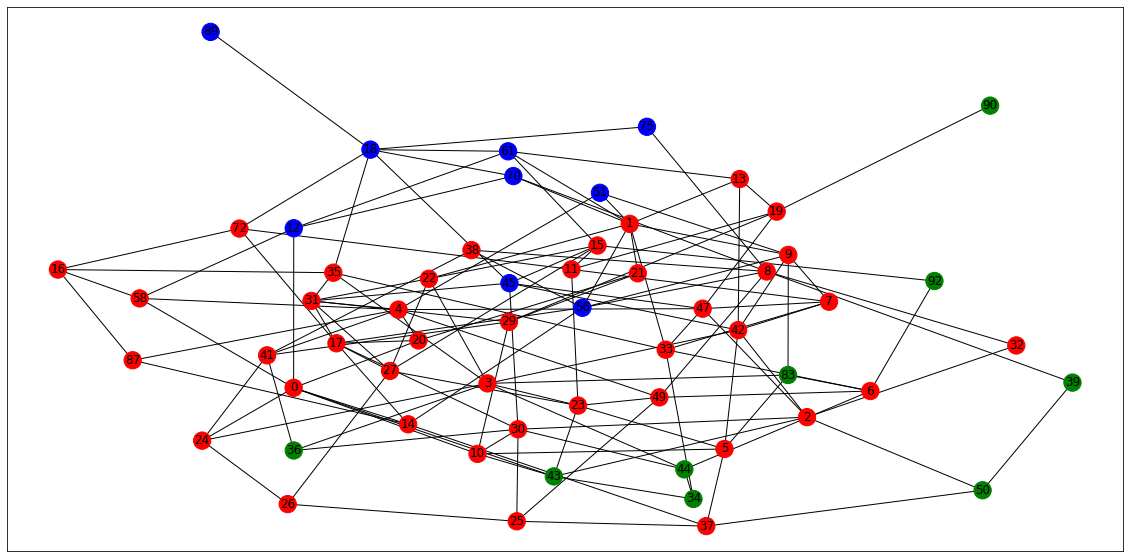

In [76]:
g1_nodes = g1.nodes()
g2_nodes = g2.nodes()

g3 = nx.compose(g1,g2)

node_color_map = []
for node in g3:
    if node in g1_nodes and node in g2_nodes:
        node_color_map.append('red')
    elif node in g1_nodes:
        node_color_map.append('blue')
    else: 
        node_color_map.append('green')
        
plt.figure(figsize=(20,10))
nx.draw_networkx(g3, node_color=node_color_map)

## calculate overlapping the number of overlapping nodes

In [77]:
def number_of_overlapping_nodes(x,y):
    common = 0
    common_list = []
    for node in x:
        if node in y:
            common += 1
            common_list.append(node)
    if(not common):
        return ("No overlapping nodes exist")
    else:
        return common, common_list

In [78]:
ovl_nodes_num, ovl_nodes = number_of_overlapping_nodes(g1.nodes(), g2.nodes())
print("overlapping nodes {}:".format(ovl_nodes))
print("number of overlapping nodes: {}".format(ovl_nodes_num))

overlapping nodes [6, 33, 1, 9, 7, 11, 15, 22, 27, 17, 14, 0, 37, 5, 25, 10, 26, 24, 29, 19, 21, 13, 20, 42, 2, 30, 32, 8, 38, 41, 4, 31, 47, 49, 58, 23, 3, 16, 35, 72, 87]:
number of overlapping nodes: 41


## adjust the number of overlapping nodes

In [79]:
def edge_reverse(edge):
    temp = edge[0]
    edge[0] = edge[1]
    edge[1] = temp
    
    return edge

def prune_overlapping_nodes(g, g1, g2, expected_ovl_num, expected_non_ovl_num):
    ''' reduce the number of overlapping nodes'''
    ovl_num, ovl_nodes = number_of_overlapping_nodes(g1.nodes(), g2.nodes())

    g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
    g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
    
    remaining_node_list = list(g.nodes() - g1.nodes())
    remaining_node_list = [node for node in remaining_node_list if node not in g2_non_ovl_n_list]
    
    g1_reduced_n_list = []
    g2_reduced_n_list = []
    i = 1
    ''' adjust the number of overlapping nodes'''
    while ovl_num > expected_ovl_num: 
        if i == 1:
            rand_node = np.random.choice(ovl_nodes)
            g1.remove_node(rand_node)
            ovl_nodes.remove(rand_node)
            g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
            g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
            added = 0
            while added != 1:
                add_rand_node = np.random.choice(remaining_node_list)
                edge_list = list(map(lambda e: list(e), list(g.edges(add_rand_node, data=True))))
                for i in range(0, len(edge_list)):
                    if edge_list[i][1] in list(g1.nodes()):
                        g1.add_node(add_rand_node)
                        g1.add_edge(edge_list[i][0], edge_list[i][1])
                        g1.add_edge(edge_reverse(edge_list[i])[0], edge_reverse(edge_list[i])[1])
                        added = 1
                        remaining_node_list = list(g.nodes() - g1.nodes())
                        remaining_node_list = [node for node in remaining_node_list if node not in g2_non_ovl_n_list]
                    else:
                        continue
            ovl_num -= 1
            i = 2  
        else:
            rand_node = np.random.choice(ovl_nodes)
            g2.remove_node(rand_node)
            ovl_nodes.remove(rand_node)
            g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
            g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
            added = 1
            while added != 0:
                add_rand_node = np.random.choice(remaining_node_list)
                edge_list = list(map(lambda e: list(e), list(g.edges(add_rand_node, data=True))))
                for i in range(0, len(edge_list)):
                    if edge_list[i][1] in list(g2.nodes()):
                        g2.add_node(add_rand_node)
                        g2.add_edge(edge_list[i][0], edge_list[i][1])
                        g2.add_edge(edge_reverse(edge_list[i])[0], edge_reverse(edge_list[i])[1])
                        added = 0
                        remaining_node_list = list(g.nodes() - g1.nodes())
                        remaining_node_list = [node for node in remaining_node_list if node not in g2_non_ovl_n_list]
                    else:
                        continue
            ovl_num -= 1
            i = 1  
            
    for curr_node in g1.nodes():
        if len(list(nx.all_neighbors(g1, curr_node))) == 0:
            g1.remove_node(curr_node) 
            
    for curr_node in g2.nodes():
        if len(list(nx.all_neighbors(g2, curr_node))) == 0:
            g2.remove_node(curr_node) 
            
    return g1, g2         

In [80]:
g1, g2 = prune_overlapping_nodes(original_G, g1, g2, expected_ovl_num, expected_non_ovl_num)

In [81]:
ovl_nodes_num, ovl_nodes = number_of_overlapping_nodes(g1.nodes(), g2.nodes())
print("overlapping nodes : {}".format(ovl_nodes))
print("number of overlapping nodes: {}".format(ovl_nodes_num))

overlapping nodes : [9, 5, 21, 38, 49, 28]
number of overlapping nodes: 6


In [82]:
print("number of g1 nodes: {}".format(g1.number_of_nodes()))
print("number of g2 nodes: {}".format(g2.number_of_nodes()))

number of g1 nodes: 50
number of g2 nodes: 50


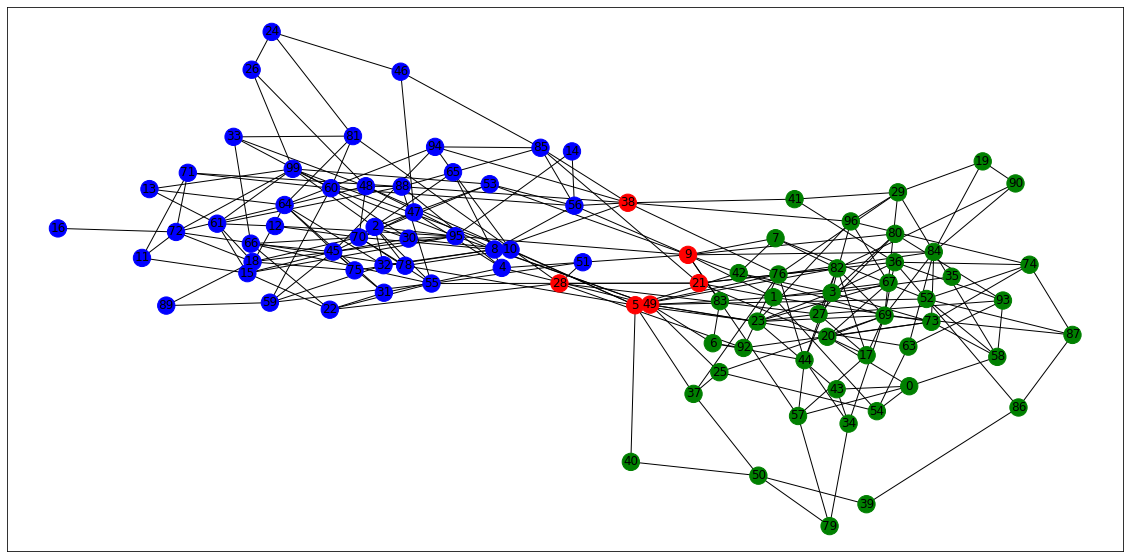

In [83]:
g1_nodes = g1.nodes()
g2_nodes = g2.nodes()

g3 = nx.compose(g1,g2)

node_color_map = []
for node in g3:
    if node in g1_nodes and node in g2_nodes:
        node_color_map.append('red')
    elif node in g1_nodes:
        node_color_map.append('blue')
    else: 
        node_color_map.append('green')
        
plt.figure(figsize=(20,10))
nx.draw_networkx(g3, node_color=node_color_map)

In [84]:
def augment_overlapping_nodes(g, g1, g2, expected_ovl_num, expected_non_ovl_num):
    ''' increase the number of overlapping nodes'''
    ovl_num, ovl_nodes = number_of_overlapping_nodes(g1.nodes(), g2.nodes())
    
    g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
    g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
    
    g1_reduced_n_list = []
    g2_reduced_n_list = []
    
    a = 1
    ''' adjust the number of overlapping nodes'''
    while ovl_num != expected_ovl_num: 
        if a == 1:
            rand_node = np.random.choice(g1_non_ovl_n_list)
            edge_list = list(map(lambda e: list(e), list(g.edges(rand_node, data=True))))
            for i in range(0, len(edge_list)):
                if edge_list[i][1] in list(g2.nodes()):
                    g2.add_node(rand_node)
                    g2.add_edge(edge_list[i])
                    g2.add_edge(edge_reverse(edge_list[i]))
                    ovl_num += 1
                    ovl_nodes.append(rand_node)
                    g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
                    g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
                    a = 2
                    break
                else:
                    continue
            a = 2
                   
            
        else:
            rand_node = np.random.choice(g2_non_ovl_n_list)
            edge_list = list(map(lambda e: list(e), list(g.edges(rand_node, data=True))))
            for i in range(0, len(edge_list)):
                if edge_list[i][1] in list(g1.nodes()):
                    g1.add_node(rand_node)
                    g1.add_edge(edge_list[i])
                    g1.add_edge(edge_reverse(edge_list[i]))
                    ovl_num += 1
                    ovl_nodes.append(rand_node)
                    g1_non_ovl_n_list = list(g1.nodes() - ovl_nodes)
                    g2_non_ovl_n_list = list(g2.nodes() - ovl_nodes)
                    a = 1
                    break
                else:
                    continue
            a = 1

    return g1, g2

## Final method

In [96]:
def generate_overlapping_graphs(G, p):
    ''' calculate the number of overlapping and non_overlapping nodes '''
    expected_ovl_num, expected_non_ovl_num = network_split(original_G, p)
    total_n_num = expected_ovl_num, expected_non_ovl_num
    
    #if p > 0.5:
    ''' generate G1 and G2 from G'''
    g1 = generate_subgraph(original_G, total_n_num)
    g2 = generate_subgraph(original_G, total_n_num)

    g1_nodes = g1.nodes()
    g2_nodes = g2.nodes()

    ovl_num, ovl_nodes = number_of_overlapping_nodes(g1_nodes, g2_nodes)

    if ovl_num > expected_ovl_num:
        g1, g2 = prune_overlapping_nodes(G, g1, g2, expected_ovl_num, expected_non_ovl_num, ovl_nodes)

    elif ovl_num < expected_ovl_num:
        g1, g2 = augment_overlapping_nodes(G, g1, g2, expected_ovl_num, expected_non_ovl_num)
    else:
        print("the number of overlapping nodes corresponds to expected number!")


    return g1, g2

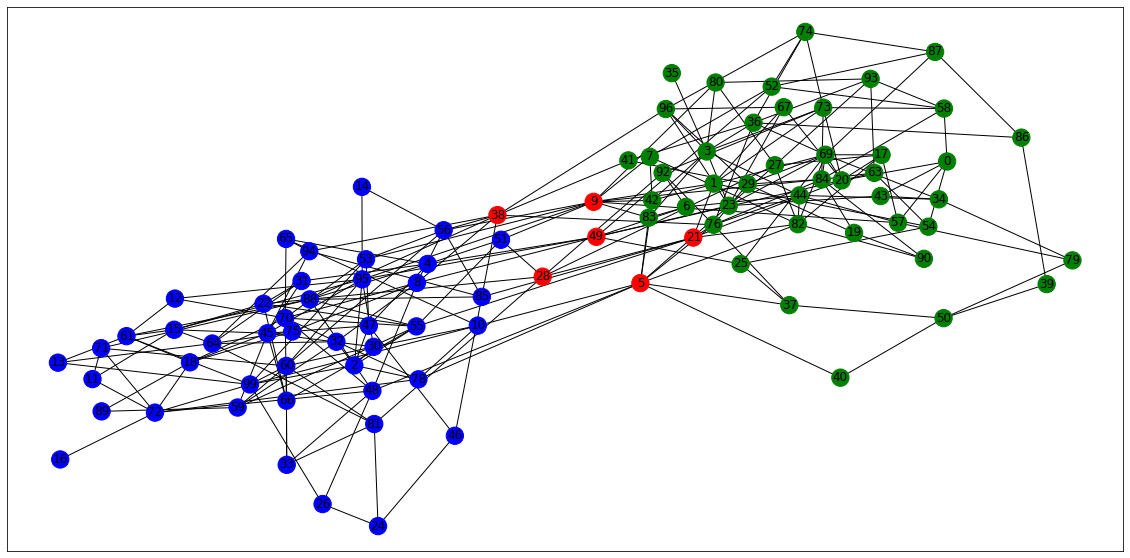

In [97]:
g1_nodes = g1.nodes()
g2_nodes = g2.nodes()

g3 = nx.compose(g1,g2)

node_color_map = []
for node in g3:
    if node in g1_nodes and node in g2_nodes:
        node_color_map.append('red')
    elif node in g1_nodes:
        node_color_map.append('blue')
    else: 
        node_color_map.append('green')
        
plt.figure(figsize=(20,10))
nx.draw_networkx(g3, node_color=node_color_map)